# Hard Drive Failure Detection

https://www.kaggle.com/jackywangkaggle/hard-drive-data-and-stats

__Context:__
How often does our hard disks fail? Check out the test data form Backblaze!

Each day, the Backblaze data center takes a snapshot of each operational hard drive. This snapshot includes basic drive information along with the S.M.A.R.T. statistics reported by that drive. The daily snapshot of one drive is one record or row of data. All of the drive snapshots for a given day are collected into a file consisting of a row for each active hard drive. The format of this file is a "csv" (Comma Separated Values) file. Each day this file is named in the format YYYY-MM-DD.csv, for example, 2019-07-01.csv.

__Content:__
The first row of the each file contains the column names, the remaining rows are the actual data. The columns are as follows:

Date – The date of the file in yyyy-mm-dd format.
Serial Number – The manufacturer-assigned serial number of the drive.
Model – The manufacturer-assigned model number of the drive.
Capacity – The drive capacity in bytes.
Failure – Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.

__Evaluation Metrics:__

Limitation of previous studies is the choice of evaluation metrics which generally coincide with the detection and false alarm rates. This is a relevant choice for balanced datasets but, as operational datasets are extremely unbalanced in favour of healthy samples, even a low false alarm rate in the
range of 1% could translate into poor performances. Therefore, we rather report precision, recall metrics and f1-score.

False Alarm Ratio = False Alarms/Total number of alarms

i.e., False Alarm Ratio = (Number of drives wrongly detected as failures)/(Total number of actually failed drives)

precision = true positive/(true positive + false positive)

i.e., __Precision = (Number of drives that are actually failures)/(Total number of drives that are predicted to be failures)__

recall = true positive/(true positive + false negative)

i.e., __Recall = (Number of drives predicted correctly as failures)/(Total number of drives that are actually failures)__

__F1-Score = 2 * (precision * recall) / (precision + recall)__

We decide to report precision instead of false alarm rate: due to the high class imbalance, even a small false alarm rate could translate into poor performances. Indeed, a misclassification of only 1% of the healthy samples would result in 100 false alarms for every 10,000 healthy samples. On average, since there are only 2 failure samples for every 10,000 healthy samples, it means that we have 50 false alarms for every detected failure if we assume 100% recall on the failure samples, and consequently a precision below 2%. Similarly, we can note that a constant prediction in favour of the majority class would result in an accuracy of 99.98%. Hence we choose to report precision, recall and f1-score.

__Acknowledgements:__

Data is sourced from: https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data.

__Research-papers:__

https://hal.archives-ouvertes.fr/hal-01703140/document

http://cs229.stanford.edu/proj2017/final-reports/5242080.pdf

## Exploratory Data Analysis

In [2]:
import warnings 
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd 
import os
from os import listdir
import seaborn as sb
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.utils import resample
from datetime import datetime
from datetime import timedelta
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook as tqdm

In [3]:
os.chdir(r"D:\vysh\Hard_drive_failure")

### 1. Reading Data

In [4]:
df=pd.read_csv("july_august"+"\\"+listdir("july_august")[0])
for file in listdir("july_august")[1:]:
    df=df.append(pd.read_csv("july_august"+"\\"+file))

In [5]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2019-07-01,Z305B2QN,ST4000DM000,4000787030016,0,119.0,224077128.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,196781888.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,76.0,37537312.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,100.0,1592144.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.tail()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
112980,2019-08-31,ZA10MCEQ,ST8000DM002,8001563222016,0,81.0,113942496.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112981,2019-08-31,ZCH0CRTK,ST12000NM0007,12000138625024,0,80.0,105578584.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112982,2019-08-31,AAGA7W2H,HGST HUH721212ALN604,12000138625024,0,100.0,0.0,132.0,96.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112983,2019-08-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112984,2019-08-31,PL2331LAHDS4TJ,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,133.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
df.reset_index(inplace=True,drop=True)
df.tail(2)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
6931136,2019-08-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6931137,2019-08-31,PL2331LAHDS4TJ,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,133.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=129)

In [10]:
print("Number of data points: ",df.shape[0]," Number of features: ",df.shape[1])

Number of data points:  6931138  Number of features:  129


https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/

Backblaze has been using the following five SMART stats as a means of helping determine if a drive is going to fail.

    ATTRIBUTE		DESCRIPTION
    SMART 5		  Reallocated Sectors Count
    SMART 187		Reported Uncorrectable Errors
    SMART 188		Command Timeout
    SMART 197		Current Pending Sector Count
    SMART 198		Uncorrectable Sector Count
    
http://cs229.stanford.edu/proj2017/final-reports/5242080.pdf

Including BackBlaze’s original five features SMART 5, 187, 188, 197, and 198 because they were selected by BackBlaze for their high correlation to HDD failure. Also including 5 additional features: SMART 9, 193, 194, 241, 242. These SMART attributes were chosen based on an analysis by El-Shimi where he reported the associated weights of each SMART feature in his random forest model [El-Shimi]. Aside from the SMART 5,187, 188, 197 and 198, SMART 9, 193, 194, 241 and 242 had the highest weight values reported.

### 2. Selecting Features

In [11]:
#we are selecting only below features
features=['date','model','serial_number','capacity_bytes', 'failure','smart_5_raw','smart_9_raw','smart_12_raw','smart_187_raw',
         'smart_188_raw','smart_189_raw','smart_190_raw','smart_193_raw','smart_194_raw','smart_197_raw','smart_198_raw',
         'smart_199_raw','smart_200_raw','smart_241_raw','smart_242_raw']

In [12]:
df_new=df[features]
df_new.head()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_241_raw,smart_242_raw
0,2019-07-01,ST4000DM000,Z305B2QN,4000787030016,0,0.0,31048.0,13.0,0.0,0.0,0.0,21.0,34185.0,21.0,0.0,0.0,0.0,NaN,4.863399e+10,1.425050e+11
1,2019-07-01,ST12000NM0007,ZJV0XJQ4,12000138625024,0,0.0,8097.0,2.0,0.0,0.0,NaN,28.0,2329.0,28.0,0.0,0.0,0.0,0.0,4.373717e+10,8.853983e+10
2,2019-07-01,ST12000NM0007,ZJV0XJQ3,12000138625024,0,0.0,5127.0,1.0,0.0,0.0,NaN,31.0,1783.0,31.0,0.0,0.0,0.0,0.0,3.967749e+10,2.115116e+10
3,2019-07-01,ST12000NM0007,ZJV0XJQ0,12000138625024,0,0.0,8692.0,6.0,0.0,0.0,NaN,24.0,873.0,24.0,0.0,0.0,0.0,0.0,4.720428e+10,6.852008e+10
4,2019-07-01,HGST HMS5C4040ALE640,PL1331LAHG1S4H,4000787030016,0,0.0,21121.0,9.0,NaN,NaN,NaN,NaN,340.0,31.0,0.0,0.0,0.0,NaN,NaN,NaN


In [13]:
df_new=df[features]
df_new.head()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_241_raw,smart_242_raw
0,2019-07-01,ST4000DM000,Z305B2QN,4000787030016,0,0.0,31048.0,13.0,0.0,0.0,0.0,21.0,34185.0,21.0,0.0,0.0,0.0,NaN,4.863399e+10,1.425050e+11
1,2019-07-01,ST12000NM0007,ZJV0XJQ4,12000138625024,0,0.0,8097.0,2.0,0.0,0.0,NaN,28.0,2329.0,28.0,0.0,0.0,0.0,0.0,4.373717e+10,8.853983e+10
2,2019-07-01,ST12000NM0007,ZJV0XJQ3,12000138625024,0,0.0,5127.0,1.0,0.0,0.0,NaN,31.0,1783.0,31.0,0.0,0.0,0.0,0.0,3.967749e+10,2.115116e+10
3,2019-07-01,ST12000NM0007,ZJV0XJQ0,12000138625024,0,0.0,8692.0,6.0,0.0,0.0,NaN,24.0,873.0,24.0,0.0,0.0,0.0,0.0,4.720428e+10,6.852008e+10
4,2019-07-01,HGST HMS5C4040ALE640,PL1331LAHG1S4H,4000787030016,0,0.0,21121.0,9.0,NaN,NaN,NaN,NaN,340.0,31.0,0.0,0.0,0.0,NaN,NaN,NaN


In [14]:
df_new.describe()

,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_241_raw,smart_242_raw
count,6.931138e+06,6.931138e+06,6.922632e+06,6.926634e+06,6.926634e+06,5.018369e+06,5.018369e+06,2.866741e+06,5.018369e+06,6.891325e+06,6.926634e+06,6.922632e+06,6.922632e+06,6.922632e+06,2.274797e+06,5.098391e+06,5.098391e+06
mean,8.318259e+12,5.987473e-05,1.136785e+01,1.854428e+04,6.283129e+00,5.157405e-01,1.676737e+08,5.671116e+00,2.879593e+01,1.245554e+04,2.880067e+01,1.242572e-01,1.155867e-01,2.974305e-01,3.834833e+03,5.158254e+10,1.219022e+11
std,3.607420e+12,7.737645e-03,3.862803e+02,1.060149e+04,1.130265e+01,1.168325e+02,4.107952e+09,4.718943e+02,6.680044e+00,4.318239e+04,6.229702e+00,2.807007e+01,2.805990e+01,1.299975e+01,4.135643e+04,1.287042e+10,1.424598e+11
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,1.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.000787e+12,0.000000e+00,0.000000e+00,1.047800e+04,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,4.490000e+02,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.762827e+10,1.028664e+11
50%,8.001563e+12,0.000000e+00,0.000000e+00,1.748900e+04,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,1.322000e+03,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.227772e+10,1.312983e+11
75%,1.200014e+13,0.000000e+00,0.000000e+00,2.742300e+04,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01,1.230700e+04,3.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.962854e+10,1.494542e+11
max,1.400052e+13,1.000000e+00,6.463200e+04,5.647200e+04,9.000000e+02,6.553500e+04,6.013057e+11,6.553500e+04,6.000000e+01,1.482412e+06,6.000000e+01,4.933600e+04,4.933600e+04,2.909000e+03,9.974060e+05,2.031607e+11,2.640232e+13


In [17]:
df_new['model'].unique()

array(['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640',
       'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640',
       'TOSHIBA MG07ACA14TA', 'HGST HUH721212ALN604',
       'HGST HUH721212ALE600', 'TOSHIBA MQ01ABF050', 'ST500LM030',
       'ST6000DX000', 'ST10000NM0086', 'TOSHIBA MQ01ABF050M',
       'WDC WD5000LPVX', 'ST500LM012 HN', 'HGST HUH728080ALE600',
       'TOSHIBA MD04ABA400V', 'TOSHIBA HDWF180', 'ST8000DM005',
       'Seagate SSD', 'ST4000DM005', 'WDC WD5000LPCX',
       'HGST HDS5C4040ALE630', 'DELLBOSS VD', 'ST500LM021',
       'Hitachi HDS5C4040ALE630', 'HGST HUS726040ALE610',
       'Seagate BarraCuda SSD ZA500CM10002',
       'Seagate BarraCuda SSD ZA2000CM10002', 'HGST HUH721010ALE600',
       'TOSHIBA HDWE160', 'WDC WD5000BPKT', 'ST6000DM001', 'WDC WD60EFRX',
       'ST320LT007', 'ST8000DM004', 'ST9250315AS', 'HGST HMS5C4040BLE641',
       'ST1000LM024 HN', 'ST6000DM004',
       'Seagate BarraCuda SSD ZA250CM10002', 'ST12000NM0117'],
      dtype=object)

### 3. Selecting data of segate models

In [89]:
df_segate=df_new[df_new['model']=='ST4000DM000']
for model in df_new['model'].unique()[1:]:
    if model[:2]  == 'ST' or model[:2] == 'Se':
        print(model)
        row_df=df_new[df_new['model']==model]
        df_segate=pd.concat([df_segate,row_df])

ST12000NM0007
ST8000NM0055
ST8000DM002
ST500LM030
ST6000DX000
ST10000NM0086
ST500LM012 HN
ST8000DM005
Seagate SSD
ST4000DM005
ST500LM021
Seagate BarraCuda SSD ZA500CM10002
Seagate BarraCuda SSD ZA2000CM10002
ST6000DM001
ST320LT007
ST8000DM004
ST9250315AS
ST1000LM024 HN
ST6000DM004
Seagate BarraCuda SSD ZA250CM10002
ST12000NM0117


In [90]:
df_segate.reset_index(inplace=True,drop=True)

In [91]:
df_segate.tail()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_241_raw,smart_242_raw
5054359,2019-08-30,ST12000NM0117,ZCH09ZK6,12000138625024,0,0.0,0.0,1.0,0.0,0.0,NaN,19.0,4.0,19.0,0.0,0.0,0.0,0.0,0.000000e+00,116256.0
5054360,2019-08-30,ST12000NM0117,ZCH0A05S,12000138625024,0,0.0,0.0,1.0,0.0,0.0,NaN,21.0,3.0,21.0,0.0,0.0,0.0,0.0,0.000000e+00,107952.0
5054361,2019-08-31,ST12000NM0117,ZCH09ZK6,12000138625024,0,0.0,32.0,2.0,0.0,0.0,NaN,21.0,163.0,21.0,0.0,0.0,0.0,0.0,9.246075e+07,1917606.0
5054362,2019-08-31,ST12000NM0117,ZCH0A0GF,12000138625024,0,0.0,16.0,1.0,0.0,0.0,NaN,36.0,4.0,36.0,0.0,0.0,0.0,0.0,9.817738e+08,665559098.0
5054363,2019-08-31,ST12000NM0117,ZCH0A05S,12000138625024,0,0.0,32.0,1.0,0.0,0.0,NaN,25.0,29.0,25.0,0.0,0.0,0.0,0.0,1.141221e+09,135302740.0


In [92]:
df_segate.to_csv('df_segate.csv',index=False)

### 4. Uni-Variate Analysis

#### 4.1. Uni-Variate Analysis: Failure

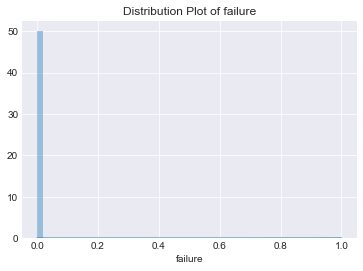

In [23]:
sb.set_style('darkgrid')
sb.distplot(df_segate['failure'])
plt.title("Distribution Plot of failure")
plt.show()

In [24]:
df_segate[df_segate['failure']==0].shape

(5053997, 20)

In [26]:
df_segate[df_segate['failure']==1].shape

(367, 20)

__From the above plot, we can observe that the data set is highly imbalances with only a few number of failure(failure=1)__

#### 4.2. Uni-Variate Analysis: smart_5_raw

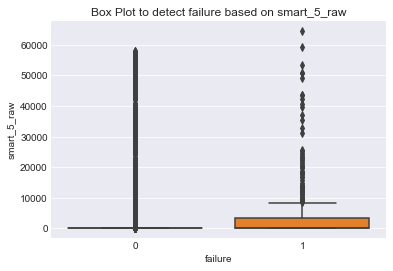

In [27]:
sb.boxplot(x='failure',y='smart_5_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_5_raw")
plt.show()

__From the above plot, we can observe that most of the drives are working for different range values of smart_5_raw and most of failures occurred when smart_5_raw is in the range of 0 to 10000__

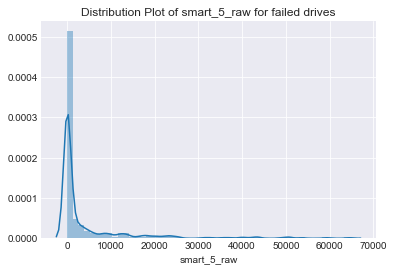

In [29]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_5_raw'].dropna())
plt.title("Distribution Plot of smart_5_raw for failed drives")
plt.show()

__From the above plots, we can observe that most of the failures(failure=1) occurred when smart_5_raw values are in the range of 0 to 10000 and few failures in the range of 20000 and one failure in the range of 70000__

#### 4.3. Uni_Variate Analysis: smart_9_raw

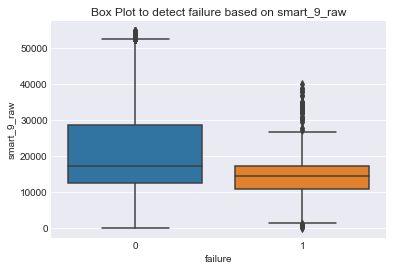

In [30]:
sb.boxplot(x='failure',y='smart_9_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_9_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_9_raw values in the range of 12000 to 29000. However, some failed drives also have smart_9_raw values in the range of 10000 to 18000__

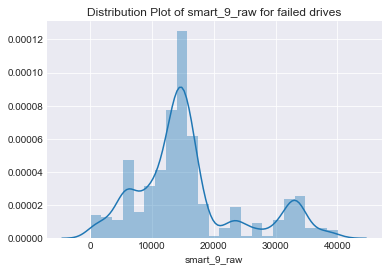

In [32]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_9_raw'].dropna())
plt.title("Distribution Plot of smart_9_raw for failed drives")
plt.show()

__From the above plots, we can observe that most of the failures occurred when smart_9_raw is in the range of 10000 to 20000__

#### 4.4. Uni-Variate Analysis: smart_187_raw

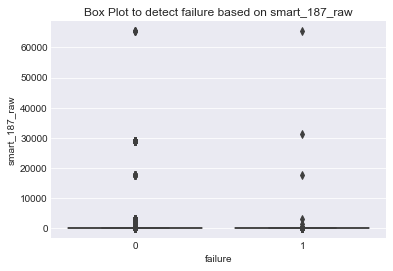

In [33]:
sb.boxplot(x='failure',y='smart_187_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_187_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_187_raw values in different ranges and most of the failures when smart_187_raw value is 0__

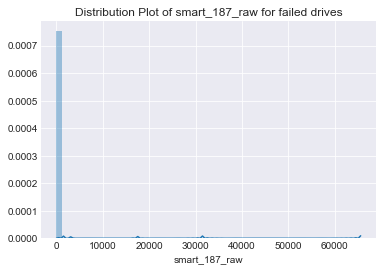

In [34]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_187_raw'].dropna())
plt.title("Distribution Plot of smart_187_raw for failed drives")
plt.show()

In [38]:
temp=df_segate[df_segate['smart_187_raw']==0]
temp[temp['failure']==1].shape

(161, 20)

In [39]:
temp=df_segate[df_segate['smart_187_raw']>0]
temp=temp[temp['smart_187_raw']<=1000]
temp[temp['failure']==1].shape

(192, 20)

In [41]:
temp=df_segate[df_segate['smart_187_raw']>=50000]
temp[temp['failure']==1].shape

(1, 20)

In [42]:
temp=df_segate[np.isnan(df_segate['smart_187_raw'])]
temp[temp['failure']==1].shape

(9, 20)

__From the above plots, we can observe that most of the failures occurred when smart_187_raw values are in the range of 0 to 1000 and only one failure occurred when the values are greater than 50000 and there are 9 failures when smart_187_raw is NaN__

#### 4.5. Uni-Variate Analysis: smart_188_raw

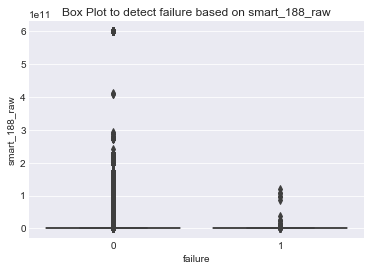

In [43]:
sb.boxplot(x='failure',y='smart_188_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_188_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_188_raw values in very high ranges of 1e11__

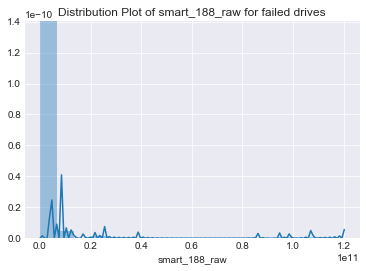

In [44]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_188_raw'].dropna())
plt.title("Distribution Plot of smart_188_raw for failed drives")
plt.show()

In [45]:
temp=df_segate[df_segate['smart_188_raw']==0]
temp[temp['failure']==1].shape

(312, 20)

In [46]:
temp=df_segate[df_segate['smart_188_raw']>0]
temp[temp['failure']==1].shape

(46, 20)

In [47]:
temp=df_segate[np.isnan(df_segate['smart_188_raw'])]
temp[temp['failure']==1].shape

(9, 20)

__From the above plots, we can observe that most of the failures(312) are when smart_188_raw value is zero and 46 failures occured when the values are very high. Also, there are 9 failures when smart_188_raw is NaN__

#### 4.6. Uni-Variate Analysis: smart_193_raw

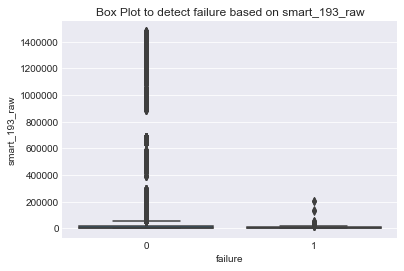

In [48]:
sb.boxplot(x='failure',y='smart_193_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_193_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_193_raw values in different ranges from 0 to 1400000__

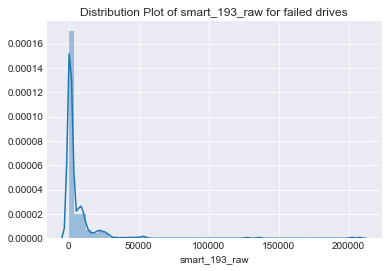

In [49]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_193_raw'].dropna())
plt.title("Distribution Plot of smart_193_raw for failed drives")
plt.show()

In [50]:
temp=df_segate[df_segate['smart_193_raw']<=10000]
temp[temp['failure']==1].shape

(302, 20)

In [51]:
temp=df_segate[df_segate['smart_193_raw']>10000]
temp=temp[temp['smart_193_raw']<=50000]
temp[temp['failure']==1].shape

(49, 20)

In [52]:
temp=df_segate[np.isnan(df_segate['smart_193_raw'])]
temp[temp['failure']==1].shape

(9, 20)

__From the above plots and analysis, we can observe that most of the failures occurred when smart_193_raw is in the range of 0 to 10000 and few failures in the range of 10000 to 50000. There are 9 failures when smart_193_raw is NaN__

#### 4.7. Uni-Variate Analysis: smart_194_raw

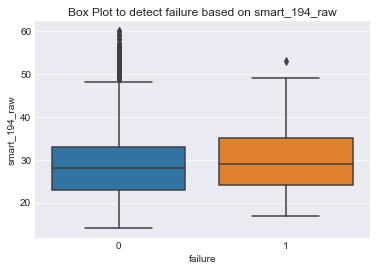

In [53]:
sb.boxplot(x='failure',y='smart_194_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_194_raw")
plt.show()

__From the above plot, we can observe that both working and failed drives have smart_194_raw values in almost same ranges from 25 to 35__

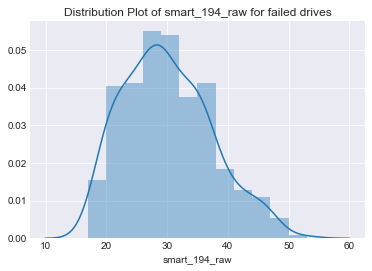

In [55]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_194_raw'].dropna())
plt.title("Distribution Plot of smart_194_raw for failed drives")
plt.show()

__From the above plots, we can observe that most failures occurred when smart_194_raw values are in the range of 20 to 40__

#### 4.8. Uni-Variate Analysis: smart_197_raw

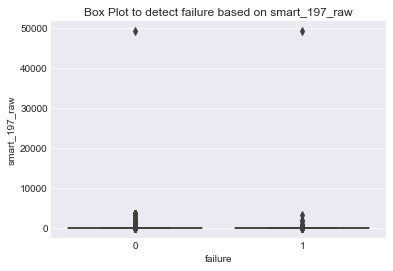

In [56]:
sb.boxplot(x='failure',y='smart_197_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_197_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_197_raw values in the range of 0 to 3000 and also failed drives have same range of values__

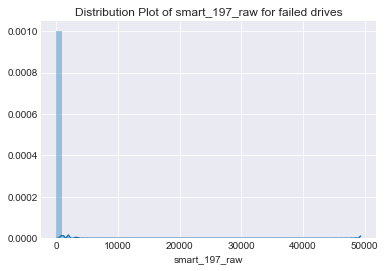

In [58]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_197_raw'].dropna())
plt.title("Distribution Plot of smart_197_raw for failed drives")
plt.show()

In [59]:
temp=df_segate[df_segate['smart_197_raw']==0]
temp[temp['failure']==1].shape

(248, 20)

In [67]:
temp=df_segate[df_segate['smart_197_raw']>0]
temp=temp[temp['smart_197_raw']<2500]
temp[temp['failure']==1].shape

(113, 20)

__From the above plots, we can observe that all failures occurred when smart_197_raw values are in the range of 0 to 3000 and most failures occurred when the value is 0__

#### 4.9. Uni-Variate Analysis: smart_198_raw

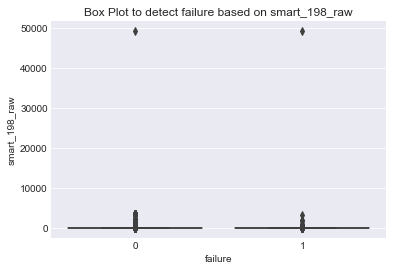

In [68]:
sb.boxplot(x='failure',y='smart_198_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_198_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_198_raw values in the range of 0 to 3000 and failed drives also have almost same range of values__

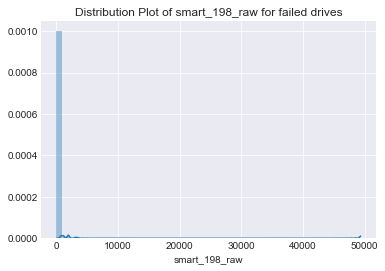

In [70]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_198_raw'].dropna())
plt.title("Distribution Plot of smart_198_raw for failed drives")
plt.show()

In [71]:
temp=df_segate[df_segate['smart_198_raw']==0]
temp[temp['failure']==1].shape

(249, 20)

In [76]:
temp=df_segate[df_segate['smart_198_raw']>0]
temp=temp[temp['smart_198_raw']<2500]
temp[temp['failure']==1].shape

(112, 20)

__From above plot, we can observe that all the failures occurred when smart_198_raw values are in the range of 0 to 2500 and most failures occurred when the value is 0__

#### 4.10. Uni-Variate Analysis: smart_241_raw

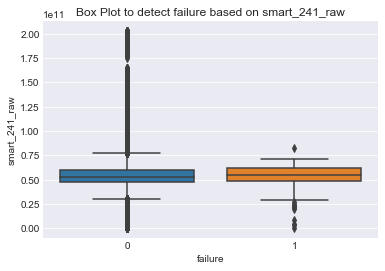

In [77]:
sb.boxplot(x='failure',y='smart_241_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_241_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_241_raw values in different ranges and have high values in the range of 1e11__

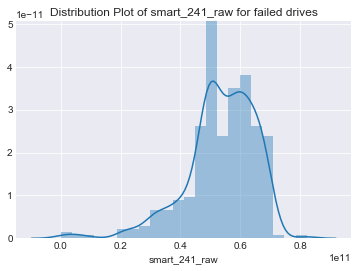

In [78]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_241_raw'].dropna())
plt.title("Distribution Plot of smart_241_raw for failed drives")
plt.show()

In [79]:
temp=df_segate[np.isnan(df_segate['smart_241_raw'])]
temp[temp['failure']==1].shape

(8, 20)

__From the above plot, we can observe that failures occurred when smart_241_raw values are in very high ranges of 0.5e11 to 0.6e11 and 8 failed drives have NaN__

#### 4.11. Uni-Variate Analysis: smart_242_raw

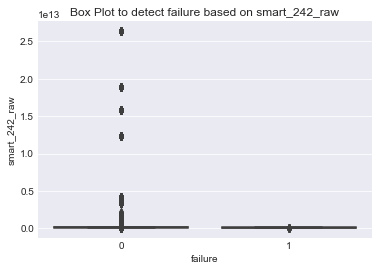

In [80]:
sb.boxplot(x='failure',y='smart_242_raw',data=df_segate)
plt.title("Box Plot to detect failure based on smart_242_raw")
plt.show()

__From the above plot, we can observe that working drives have smart_242_raw values in different ranges of values from 0 to 2.5e13__

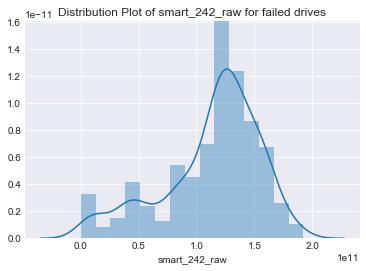

In [81]:
sb.distplot(df_segate[df_segate['failure']==1]['smart_242_raw'].dropna())
plt.title("Distribution Plot of smart_242_raw for failed drives")
plt.show()

In [82]:
temp=df_segate[['smart_242_raw','failure']]
temp=temp[temp['failure']==1].sort_values(['smart_242_raw'])
temp.head(2)

,smart_242_raw,failure
5052740,5.381000e+03,1
2920106,1.707057e+09,1


In [83]:
temp=df_segate[np.isnan(df_segate['smart_242_raw'])]
temp[temp['failure']==1].shape

(8, 20)

__From the above plot and analysis, we can observe that most of the failures occurred when smart_242_raw values are in the range of 1.062508e+10 to 1.5e+11 and 8 failed drives have NaN__

#### Summary:

1. From all the above plots, we can observe that the failures occurred for different ranges of smart attributes' values.
2. Most failures occurred when smart attributes' values are 0.

## 5. Bactrack last 15 days failures

In [4]:
#backtrack last 15 days failures
df_segate_backtrack=pd.read_csv("df_segate.csv")
new_date=[]
for date in df_segate_backtrack['date']:
    new_date.append(datetime.strptime(date,'%Y-%m-%d').date())
df_segate_backtrack['date']=new_date

failed=df_segate_backtrack[df_segate_backtrack['failure']==1]
print(failed.shape)
for serial_number in tqdm(failed.serial_number):
    d=failed[failed['serial_number']==serial_number].date.values
    temp=df_segate_backtrack[df_segate_backtrack['serial_number']==serial_number]
    temp=temp[temp.date>=(d[0]-timedelta(days=15))]
    temp=temp[temp.date<d[0]]
    indices=temp.index
    df_segate_backtrack.loc[indices,'failure']=1
failed=df_segate_backtrack[df_segate_backtrack['failure']==1]
print(failed.shape)

(367, 20)



(5204, 20)


In [6]:
df_segate_backtrack.to_csv('df_segate_backtrack.csv',index=False)

## 6. Pre-Processing

#### 6.1. Missing Values

In [93]:
#missing values
df_segate.isnull().sum()

date                    0
model                   0
serial_number           0
capacity_bytes          0
failure                 0
smart_5_raw          4688
smart_9_raw           686
smart_12_raw          686
smart_187_raw       35995
smart_188_raw       35995
smart_189_raw     2187623
smart_190_raw       35995
smart_193_raw       35995
smart_194_raw         686
smart_197_raw        4688
smart_198_raw        4688
smart_199_raw        4688
smart_200_raw     2797057
smart_241_raw       32055
smart_242_raw       32055
dtype: int64

In [94]:
null_sum=df_segate.isnull().sum()

In [95]:
'''percentage of mssing values in each column'''
features_new_2=[]
for i in df_segate.columns:
    print(i,null_sum[i]*100/df_segate.shape[0])
    if null_sum[i]*100/df_segate.shape[0] > 30:
        continue
    features_new_2.append(i)

date 0.0
model 0.0
serial_number 0.0
capacity_bytes 0.0
failure 0.0
smart_5_raw 0.09275153115208956
smart_9_raw 0.013572429686504572
smart_12_raw 0.013572429686504572
smart_187_raw 0.7121568608829915
smart_188_raw 0.7121568608829915
smart_189_raw 43.28186493889241
smart_190_raw 0.7121568608829915
smart_193_raw 0.7121568608829915
smart_194_raw 0.013572429686504572
smart_197_raw 0.09275153115208956
smart_198_raw 0.09275153115208956
smart_199_raw 0.09275153115208956
smart_200_raw 55.3394452793665
smart_241_raw 0.6342044221587523
smart_242_raw 0.6342044221587523


In [96]:
features_new_2

['date',
 'model',
 'serial_number',
 'capacity_bytes',
 'failure',
 'smart_5_raw',
 'smart_9_raw',
 'smart_12_raw',
 'smart_187_raw',
 'smart_188_raw',
 'smart_190_raw',
 'smart_193_raw',
 'smart_194_raw',
 'smart_197_raw',
 'smart_198_raw',
 'smart_199_raw',
 'smart_241_raw',
 'smart_242_raw']

__We can observe that more than 25% of the values are missing in smart_189_raw, smart_200_raw. So dropping the columns__

In [97]:
df_segate=df_segate[features_new_2]
df_segate

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_241_raw,smart_242_raw
0,2019-07-01,ST4000DM000,Z305B2QN,4000787030016,0,0.0,31048.0,13.0,0.0,0.0,21.0,34185.0,21.0,0.0,0.0,0.0,4.863399e+10,1.425050e+11
1,2019-07-01,ST4000DM000,Z305DEMG,4000787030016,0,0.0,29350.0,4.0,0.0,0.0,21.0,52185.0,21.0,0.0,0.0,0.0,4.256433e+10,1.319452e+11
2,2019-07-01,ST4000DM000,Z304K3TJ,4000787030016,0,0.0,32746.0,9.0,0.0,0.0,21.0,6864.0,21.0,0.0,0.0,0.0,4.803972e+10,1.439572e+11
3,2019-07-01,ST4000DM000,Z306WYZZ,4000787030016,0,0.0,16339.0,6.0,0.0,0.0,21.0,208.0,21.0,0.0,0.0,0.0,2.163189e+10,1.018303e+11
4,2019-07-01,ST4000DM000,S300ZP5B,4000787030016,0,0.0,35042.0,9.0,0.0,0.0,18.0,39461.0,18.0,0.0,0.0,0.0,5.860280e+10,1.360256e+11
5,2019-07-01,ST4000DM000,Z305J0TE,4000787030016,0,0.0,28873.0,8.0,0.0,0.0,30.0,2983.0,30.0,0.0,0.0,0.0,4.515116e+10,1.597192e+11
6,2019-07-01,ST4000DM000,S301NGZV,4000787030016,0,0.0,32174.0,11.0,0.0,0.0,25.0,16319.0,25.0,0.0,0.0,0.0,5.187848e+10,1.408042e+11
7,2019-07-01,ST4000DM000,Z302BV7C,4000787030016,0,0.0,35212.0,7.0,3.0,0.0,20.0,38399.0,20.0,8.0,8.0,0.0,5.735684e+10,1.447734e+11
8,2019-07-01,ST4000DM000,S3010M7R,4000787030016,0,0.0,36157.0,15.0,0.0,0.0,24.0,37401.0,24.0,0.0,0.0,0.0,5.829321e+10,1.240177e+11
9,2019-07-01,ST4000DM000,S3010M7H,4000787030016,0,0.0,35860.0,20.0,1.0,0.0,24.0,165943.0,24.0,0.0,0.0,0.0,5.027284e+10,1.512766e+11


#### 6.2. Filling Missing Values with mean

In [115]:
df_segate['smart_5_raw']=df_segate['smart_5_raw'].fillna(df_segate['smart_5_raw'].mean())
df_segate['smart_9_raw']=df_segate['smart_9_raw'].fillna(df_segate['smart_9_raw'].mean())
df_segate['smart_12_raw']=df_segate['smart_12_raw'].fillna(df_segate['smart_12_raw'].mean())
df_segate['smart_187_raw']=df_segate['smart_187_raw'].fillna(df_segate['smart_187_raw'].mean())
df_segate['smart_188_raw']=df_segate['smart_188_raw'].fillna(df_segate['smart_188_raw'].mean())
df_segate['smart_190_raw']=df_segate['smart_190_raw'].fillna(df_segate['smart_190_raw'].mean())
df_segate['smart_193_raw']=df_segate['smart_193_raw'].fillna(df_segate['smart_193_raw'].mean())
df_segate['smart_194_raw']=df_segate['smart_194_raw'].fillna(df_segate['smart_194_raw'].mean())
df_segate['smart_197_raw']=df_segate['smart_197_raw'].fillna(df_segate['smart_197_raw'].mean())
df_segate['smart_198_raw']=df_segate['smart_198_raw'].fillna(df_segate['smart_198_raw'].mean())
df_segate['smart_199_raw']=df_segate['smart_199_raw'].fillna(df_segate['smart_199_raw'].mean())
df_segate['smart_241_raw']=df_segate['smart_241_raw'].fillna(df_segate['smart_241_raw'].mean())
df_segate['smart_242_raw']=df_segate['smart_242_raw'].fillna(df_segate['smart_242_raw'].mean())

In [116]:
df_segate.isnull().sum()

date              0
model             0
serial_number     0
capacity_bytes    0
failure           0
smart_5_raw       0
smart_9_raw       0
smart_12_raw      0
smart_187_raw     0
smart_188_raw     0
smart_190_raw     0
smart_193_raw     0
smart_194_raw     0
smart_197_raw     0
smart_198_raw     0
smart_199_raw     0
smart_241_raw     0
smart_242_raw     0
dtype: int64

#### 6.3. Computing mean, std, min, max for smart_parameters row-wise

In [117]:
df_segate.columns[5:18]

Index(['smart_5_raw', 'smart_9_raw', 'smart_12_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_190_raw', 'smart_193_raw', 'smart_194_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_241_raw',
       'smart_242_raw'],
      dtype='object')

In [53]:
df_segate['mean']=df_segate[df_segate.columns[5:18]].mean(axis=1)
df_segate['std']=df_segate[df_segate.columns[5:18]].std(axis=1)
df_segate['min']=df_segate[df_segate.columns[5:18]].min(axis=1)
df_segate['max']=df_segate[df_segate.columns[5:18]].max(axis=1)
df_segate.head()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,...,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_241_raw,smart_242_raw,mean,std,min,max
0,2019-07-01,ST4000DM000,Z305B2QN,4000787030016,0,0.0,31048.0,13.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.863399e+10,1.425050e+11,1.470301e+10,4.068439e+10,0.0,1.425050e+11
1,2019-07-01,ST4000DM000,Z305DEMG,4000787030016,0,0.0,29350.0,4.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.256433e+10,1.319452e+11,1.342382e+10,3.750409e+10,0.0,1.319452e+11
2,2019-07-01,ST4000DM000,Z304K3TJ,4000787030016,0,0.0,32746.0,9.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.803972e+10,1.439572e+11,1.476900e+10,4.102428e+10,0.0,1.439572e+11
3,2019-07-01,ST4000DM000,Z306WYZZ,4000787030016,0,0.0,16339.0,6.0,0.0,0.0,...,21.0,0.0,0.0,0.0,2.163189e+10,1.018303e+11,9.497094e+09,2.837960e+10,0.0,1.018303e+11
4,2019-07-01,ST4000DM000,S300ZP5B,4000787030016,0,0.0,35042.0,9.0,0.0,0.0,...,18.0,0.0,0.0,0.0,5.860280e+10,1.360256e+11,1.497142e+10,3.981560e+10,0.0,1.360256e+11


#### 6.4. Removing negative capacity byte values

In [54]:
a=df_segate['capacity_bytes']
for i in range(0,10,1):
    p=np.percentile(a,i)
    print(i,p)

0 -1.0
1 500107862016.0
2 4000787030016.0
3 4000787030016.0
4 4000787030016.0
5 4000787030016.0
6 4000787030016.0
7 4000787030016.0
8 4000787030016.0
9 4000787030016.0


In [55]:
temp=df_segate[df_segate['capacity_bytes']<10.0]
ind=temp.index
ind

Int64Index([ 235578,  235619,  240431,  240449,  246259,  247083,  248334,
             252153,  252278,  254057,
            ...
            4955666, 4955707, 4955719, 4955766, 4955774, 4955775, 4955862,
            4955905, 4955908, 4955950],
           dtype='int64', length=674)

In [56]:
df_segate.shape

(5054364, 22)

In [57]:
df_segate.drop(df_segate.index[list(ind)],inplace=True)

In [58]:
df_segate.shape

(5053690, 22)

In [59]:
df_segate[df_segate['capacity_bytes']<10.0]

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,...,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_241_raw,smart_242_raw,mean,std,min,max


In [60]:
df_segate.to_csv('df_segate_july_august_no_backtrack.csv',index=False)